In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error, mean_absolute_error
from datetime import datetime
import json
import os

from garisom_tools import GarisomModel
from garisom_tools.optimization import GarisomOptimizationConfig
from garisom_tools.utils.metric import normalized_nash_sutcliffe_efficiency

/Users/colinpannikkat/Documents/schoolwork/FEL/garisom/03_test_data/fremont-poplar-data/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-25 15:45:11,274	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-10-25 15:45:11,425	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
pop = 1 # ccr/jla/nrv/tsz

In [4]:
def get_output_from_result(result_dir: str, params, model_dir, config_file, ground):
    results_file = os.path.join(result_dir, "results.json")
    with open(results_file, "r") as f:
        results = json.load(f)

    outputs = {}
    evals = {}

    config = GarisomOptimizationConfig.from_json(os.path.join(result_dir, "config.json"))

    for param in results.keys():
        optim_params = results[param]['parameters']
        out = GarisomModel.run(
            X=optim_params,
            params=params,
            population=pop,
            config_file=config_file,
            model_dir=model_dir,
        )
        eval = GarisomModel.evaluate_model(
            out,
            ground,
            config.metric,
            201,
            237
        )
        outputs[param] = out
        evals[param] = eval

    return outputs, evals

In [5]:
# used with older results files, keep just in case

# def get_output_from_result(result_dir: str, params, model_dir, config_file):
#     results_file = os.path.join(result_dir, "results.json")
#     with open(results_file, "r") as f:
#         results = json.load(f)

#     optim_params = results['parameters']

#     outputs = {}

#     for param, set in optim_params.items():
#         out = GarisomModel.run(
#             X=set,
#             params=params,
#             population=pop,
#             config_file=config_file,
#             model_dir=model_dir,
#         )
#         outputs[param] = out

#     return outputs

In [6]:
params = pd.read_csv("./DBG/parameters.csv")
model_dir = './garisom/02_program_code'
config_file = os.path.abspath("./DBG/configuration.csv")
result_dir=None

In [7]:
result_dir = "optimization/output/ccr-full-irrigation/leaftemp/20251022_105740"
choice = "leaftemp.c"

low = pd.read_csv("montecarlo/output/ccr/gw/20250724_230533/ci_low.csv")
high = pd.read_csv("montecarlo/output/ccr/gw/20250724_230533/ci_high.csv")

In [8]:
match pop:
    case 1:
        ground = pd.read_csv("data/ground/ccr_hourly_data.csv")
        stderr = pd.read_csv("data/ground/ccr_std_error.csv")
        leaft = pd.read_csv("data/ground/ccr_leaftemp.csv").iloc[:-1]
        # pred = pd.read_csv("./garisom/02_program_code/out/timesteps_output_POFR_CCR-COL_DBG.csv").iloc[:-1]
    case 2:
        ground = pd.read_csv("data/ground/jla_hourly_data.csv")
        stderr = pd.read_csv("data/ground/jla_std_error.csv")
        leaft = pd.read_csv("data/ground/jla_leaftemp.csv").iloc[:-1]
        # pred = pd.read_csv("./garisom/02_program_code/out/timesteps_output_POFR_JLA-JAK_DBG.csv").iloc[:-1]
    case 3:
        ground = pd.read_csv("data/ground/nrv_hourly_data.csv")
        stderr = pd.read_csv("data/ground/nrv_std_error.csv")
        leaft = pd.read_csv("data/ground/nrv_leaftemp.csv").iloc[:-1]
        # pred = pd.read_csv("./garisom/02_program_code/out/timesteps_output_POFR_NRV-NEW_DBG.csv").iloc[:-1]
    case 4:
        ground = pd.read_csv("data/ground/tsz_hourly_data.csv")
        stderr = pd.read_csv("data/ground/tsz_std_error.csv")
        leaft = pd.read_csv("data/ground/tsz_leaftemp.csv").iloc[:-1]
        # pred = pd.read_csv("./garisom/02_program_code/out/timesteps_output_POFR_TSZ-SAN_DBG.csv").iloc[:-1]

In [9]:
if result_dir is not None:
    pred_choices, evals = get_output_from_result(
        result_dir,
        params=params,
        model_dir=model_dir,
        config_file=config_file,
        ground=ground
    )
    pred = pred_choices[choice].iloc[:-1]

In [10]:
# Double check for posterity against results.json
evals[choice]

{'leaftemp.a': 0.8596672988081773,
 'leaftemp.b': 0.036660798872432517,
 'leaftemp.c': 2.420849354435235,
 'leaftemp.d': np.float64(0.8980544543084639)}

In [11]:
ground.columns

Index(['year', 'julian-day', 'standard-time', 'Solar_Wm2', 'Rain_mm',
       'Wind_ms.1', 'Tair_C', 'Tsoil_C', 'D_kPa', 'GW', 'E-MD', 'P-PD', 'P-MD',
       'leaftemp', 'leaf-air-temp-diff'],
      dtype='object')

In [12]:
pred.columns

Index(['year', 'julian-day', 'standard-time', 'solar', 'rain', 'wind', 'T-air',
       'T-soil', 'D-MD', 'P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P-PD', 'P-MD',
       'E-MD', 'GW', 'leaf-air-vpd', 'leaftemp', 'Anet-la', 'ci', 'PPFD',
       'S-P-MD', 'S-E-MD', 'S-GW', 'S-leaf-air-vpd', 'S-leaftempt',
       'S-Anet-la', 'S-ci', 'S-PPFD', 'S-E-tree', 'Anet-tree', 'Pcrit',
       'Ecrit', 'P-leaf', 'P-stem', 'P-root', 'K-stem', 'K-leaf', 'K-plant',
       'K-xylem', 'K-root-1', 'K-root-2', 'K-root-3', 'K-root-4', 'K-root-5',
       'K-root-all', 'E-root-1', 'E-root-2', 'E-root-3', 'E-root-4',
       'E-root-5', 'water-content', 'water-content-delta', 'end-rain',
       'end-ground-water', 'end-E', 'end-drainage', 'end-soil-evap', 'end-ET',
       'end-Anet-la', 'end-total-water-input', 'end-PLC-plant',
       'end-PLC-xylem', 'end-runoff', 'leaf-air-temp-diff'],
      dtype='object')

In [13]:
def cmp_pred_to_ground_metrics(columns, ground, pred, start, end):

    fit = {}

    for col in columns:

        col_ground = ground[ground['julian-day'].between(start, end)][col].dropna()
        col_pred = pred[col]

        col_pred = col_pred.loc[col_ground.index]
        
        mse = mean_squared_error(col_ground, col_pred)
        rmse = root_mean_squared_error(col_ground, col_pred)
        mape = mean_absolute_percentage_error(col_ground, col_pred)
        made = median_absolute_error(col_ground, col_pred)
        mae = mean_absolute_error(col_ground, col_pred)
        r2 = r2_score(col_ground, col_pred)
        nnse = normalized_nash_sutcliffe_efficiency(col_ground, col_pred)

        fit[col] = {
            'mse' : mse,
            'rmse' : rmse,
            'mape' : mape,
            'made' : made,
            'mae': mae,
            'r2' : r2,
            'nse' : nnse
        }

        # Plot ground vs pred with fitted line and 1:1 correspondence
        plt.figure(figsize=(8, 6))
        plt.scatter(col_ground, col_pred, label='Data Points', alpha=0.7)
        plt.plot([col_ground.min(), col_ground.max()], [col_ground.min(), col_ground.max()], 'r--', label='1:1 Line')
        
        # Fit a line to the data
        fit_coeff = np.polyfit(col_ground, col_pred, 1)
        fit_line = np.poly1d(fit_coeff)
        plt.plot(col_ground, fit_line(col_ground), 'b-', label=f'Fitted Line: y={fit_coeff[0]:.2f}x+{fit_coeff[1]:.2f}')
        
        # Add metrics as text
        plt.text(0.05, 0.95, ''.join([f'{key}: {value:.2f}\n' for key, value in fit[col].items()]), 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        
        plt.xlabel('Ground')
        plt.ylabel('Prediction')
        plt.title(f'Ground vs Prediction: {col}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return fit

In [14]:
columns = ['P-PD', 'P-MD', 'GW', 'E-MD', 'leaftemp']
start_day = 201
stress_begin = 223
predrought_cutoff = 237
drought = 240           # drought measurement period, collected 3 days after initial drought began
post_drought = 241
leaft_data_start = 205
end_day = 266

In [15]:
start_timestep = pred[pred['julian-day'] == start_day].index[0]
predrought_timestep = pred[pred['julian-day'] == predrought_cutoff + 1].index[0]
drought_timestep = pred[pred['julian-day'] == drought + 1].index[0]
post_timestep = pred[pred['julian-day'] == post_drought + 1].index[0]
stress_timestep = pred[pred['julian-day'] == stress_begin].index[0]
leaft_start_timestep = pred[pred['julian-day'] == leaft_data_start].index[0]

print(f"Start Timestep: {start_timestep}, Predrought Timestep: {predrought_timestep}, Drought Timestep: {drought_timestep}, Leaftemp Start: {leaft_start_timestep}")

Start Timestep: 0, Predrought Timestep: 888, Drought Timestep: 960, Leaftemp Start: 96


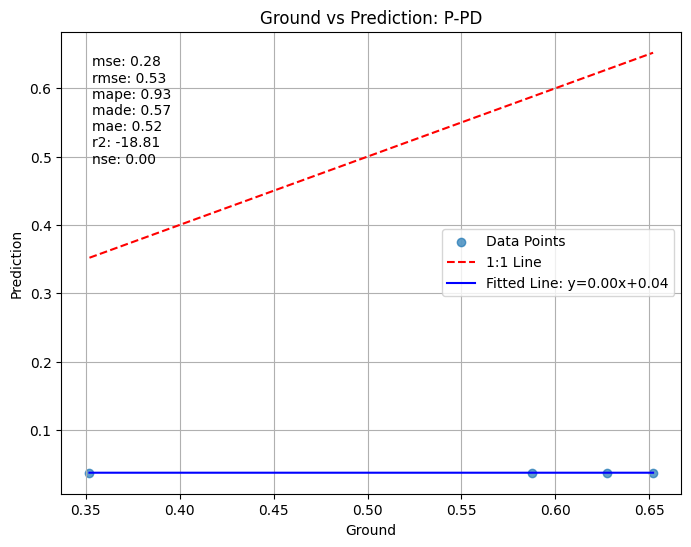

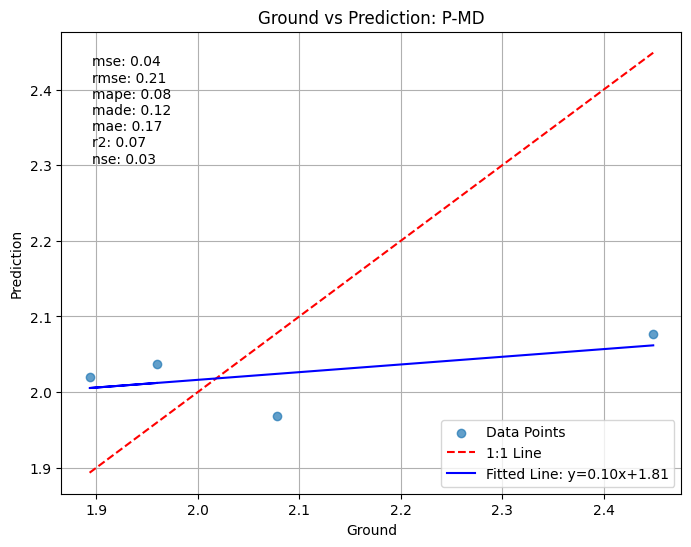

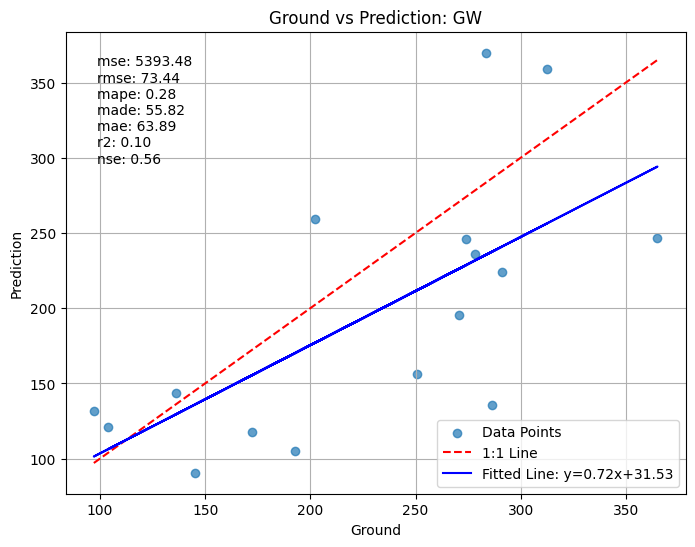

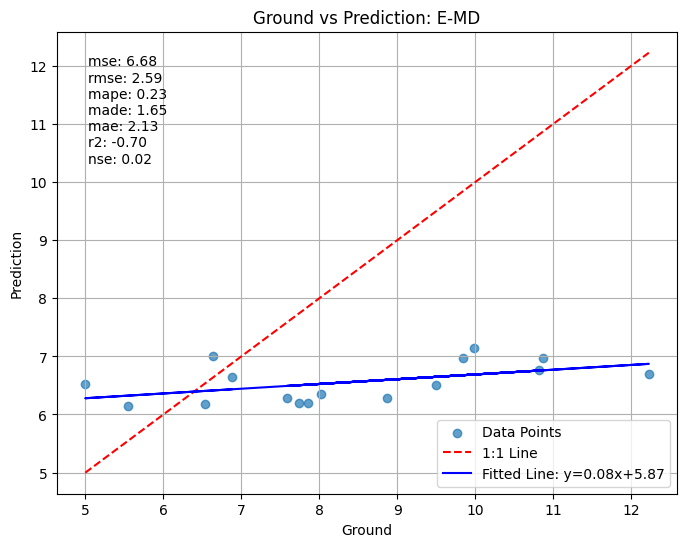

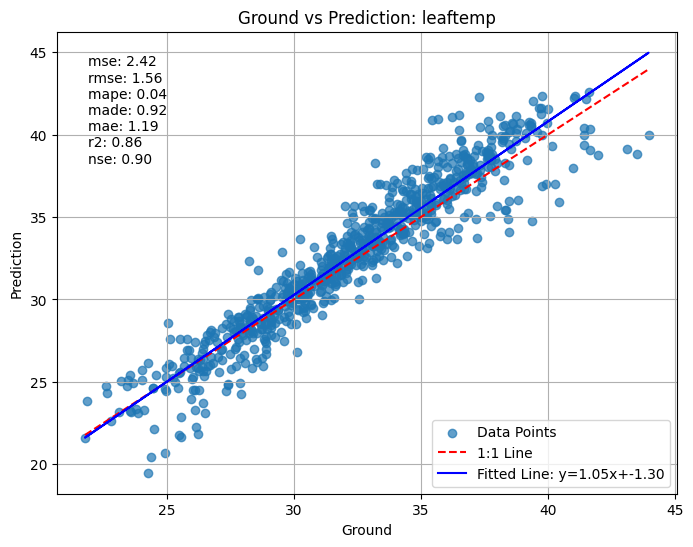

In [16]:
res = cmp_pred_to_ground_metrics(columns, ground, pred, start_day, predrought_cutoff)

In [17]:
res

{'P-PD': {'mse': 0.2818093290817828,
  'rmse': 0.5308571644819187,
  'mape': 0.9282435217929897,
  'made': np.float64(0.5699811292435),
  'mae': 0.5172824018325,
  'r2': -18.805801198538852,
  'nse': np.float64(1.1626185310163078e-11)},
 'P-MD': {'mse': 0.04301245701706242,
  'rmse': 0.2073944478935307,
  'mape': 0.07771182311422943,
  'made': np.float64(0.11783334195733364),
  'mae': 0.171280675313,
  'r2': 0.06719691769297642,
  'nse': np.float64(0.0338778774860396)},
 'GW': {'mse': 5393.483760890655,
  'rmse': 73.44034150853776,
  'mape': 0.27840677344300957,
  'made': np.float64(55.818669651998974),
  'mae': 63.886489553371604,
  'r2': 0.10308006279879911,
  'nse': np.float64(0.5635534269295246)},
 'E-MD': {'mse': 6.683256093574766,
  'rmse': 2.5851994301358583,
  'mape': 0.23213141719804656,
  'made': np.float64(1.6530127504617855),
  'mae': 2.1263854881488546,
  'r2': -0.6995062561881875,
  'nse': np.float64(0.015546130962486106)},
 'leaftemp': {'mse': 2.420849354435235,
  'rmse'

In [18]:
unit = {
    "P-PD" : "-MPa",
    "P-MD" : "-MPa",
    "GW" : "mmol s-1 m-2 (LA)",
    "E-MD" : "mmol s-1 m-2 (LA)",
    "K-plant" : "kg hr-1 m-2 (BA)",
    'leaftemp' : "C"
}

In [19]:
def plot_ground_pred(columns, stop, start=0):

    ground_pre_and_drought = ground[start:stop].copy(deep=True)
    pred_pre_and_drought = pred[start:stop].copy(deep=True)
    pre_and_drough_low = low[start:stop].copy(deep=True)
    pre_and_drought_high = high[start:stop].copy(deep=True)
    pre_and_drough_low.loc[pre_and_drough_low['GW'] > 1000, 'GW'] = 0
    pre_and_drought_high.loc[pre_and_drought_high['GW'] > 1000, 'GW'] = 0
    pred_pre_and_drought.loc[pred_pre_and_drought['GW'] > 1000, 'GW'] = 0

    for col in columns:

        # Make plot
        plt.figure(figsize=(10, 6))
        plt.scatter(range(start, stop), ground_pre_and_drought[col], label=f"Ground", color='navy')
        plt.plot(range(start, stop), pred_pre_and_drought[col], color="green", alpha=1, label=f'Prediction')
        plt.fill_between(range(start, stop), pre_and_drough_low[col], pre_and_drought_high[col], color="green", alpha=0.4, label=f'Prediction 95%')
        plt.ylim(bottom=0)
        plt.title(f"Pred versus Ground: {col}")
        plt.xlabel("Timestep")
        plt.ylabel(f"{col} {unit[col]}")
        plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
        plt.axvline(x=predrought_timestep, color='navy', linestyle='--', label='Predrought Cutoff')
        plt.axvline(x=post_timestep, color='navy', linestyle='--', label='Drought Cutoff')
        plt.legend()

    plt.figure(figsize=(10, 6))
    plt.plot(range(start, stop), pred_pre_and_drought['end-PLC-plant'], color="green", alpha=1, label=f'Prediction')
    plt.title(f"Predicted PLC")
    plt.xlabel("Timestep")
    plt.ylabel("PLC %")
    plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
    plt.axvline(x=predrought_timestep, color='navy', linestyle='--', label='Predrought Cutoff')
    plt.axvline(x=post_timestep, color='navy', linestyle='--', label='Drought Cutoff')
    plt.legend()

    # Compute cumulative PLC
    cumulative_plc = pred_pre_and_drought['end-PLC-plant'].cumsum()
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, stop), cumulative_plc, color="blue", alpha=1, label=f'Cumulative PLC')
    plt.title(f"Cumulative PLC")
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative PLC %")
    plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
    plt.axvline(x=predrought_timestep, color='navy', linestyle='--', label='Predrought Cutoff')
    plt.axvline(x=post_timestep, color='navy', linestyle='--', label='Drought Cutoff')
    plt.legend()

    # Summary stats
    print("Ground")
    display(ground_pre_and_drought[columns].describe())
    print("Pred")
    display(pred_pre_and_drought[columns].describe())

In [20]:
def get_errors(ground, stderr):
    # Get error bar
    # col_ground_stderr has the same stderr across multiple timesteps, which showcases the xerr
    # Calculate xerr as the length of consecutive identical stderr values divided by 2
    stderr_values = stderr.values
    xerr = np.zeros((2, len(ground)))
    yerr = np.zeros_like(ground)
    if len(stderr_values) > 0:
        start_idx = 0
        err_idx = 0

        # Iterate through values
        while start_idx < len(stderr_values):
            
            # Get current val and set as yerr
            current_val = stderr_values[start_idx]
            yerr[err_idx] = current_val
            run_length = 1

            # Find the number of consecutive errors
            while (start_idx + run_length < len(stderr_values)) and (stderr_values[start_idx + run_length] == current_val):
                run_length += 1

            # Get the middle and determine left and right bounds from middle and run_length
            mid = (run_length + 1) / 2
            xerr[:, err_idx] = np.array([max(0, mid - 1), max(0, run_length - mid)])
            start_idx += run_length

            # Move to next stderr
            err_idx += 1

    return xerr, yerr

In [21]:
def plot_ground_pred_two(columns, stop, start=0):
    """
    Ground versus prediction graph that only outputs for each timestep matching to the ground truth data.
    """

    ground_pre_and_drought = ground[start:stop].copy(deep=True)
    ground_stderr_pre_and_drought = stderr[start:stop].copy(deep=True)
    pred_pre_and_drought = pred[start:stop].copy(deep=True)
    # pre_and_drough_low = low[start:stop].copy(deep=True)
    # pre_and_drought_high = high[start:stop].copy(deep=True)
    # pre_and_drough_low.loc[pre_and_drough_low['GW'] > 1000, 'GW'] = 0
    # pre_and_drought_high.loc[pre_and_drought_high['GW'] > 1000, 'GW'] = 0
    pred_pre_and_drought.loc[pred_pre_and_drought['GW'] > 1000, 'GW'] = 0

    for col in columns:

        col_ground = ground_pre_and_drought[col].dropna()
        col_ground_stderr = ground_stderr_pre_and_drought[col].dropna()
        col_pred = pred_pre_and_drought[col]

        col_pred = col_pred.loc[col_ground.index]

        # Make plot
        plt.figure(figsize=(10, 6))
        plt.scatter(col_ground.index, col_ground, label=f"Ground", color='navy')
        # plt.plot(col_ground, color='navy')

        _, yerr = get_errors(col_ground, col_ground_stderr)

        plt.errorbar(
            col_ground.index,
            col_ground,
            yerr=1.96 * yerr,
            fmt='o',
            color='navy',
            alpha=0.6,
            label='Ground 95% CI',
            capsize=5,
            barsabove=True
        )
        plt.scatter(col_pred.index, col_pred, color="green", alpha=1, label=f'Prediction')
        # plt.plot(col_pred, color='green')
        # plt.fill_between(range(start, stop), pre_and_drough_low[col], pre_and_drought_high[col], color="green", alpha=0.4, label=f'Prediction 95%')
        plt.ylim(bottom=0)
        plt.title(f"Pred versus Ground: {col}")
        plt.xlabel("Timestep")
        plt.ylabel(f"{col} {unit[col]}")
        plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
        plt.axvline(x=predrought_timestep, color='navy', linestyle='--', label='Predrought Cutoff')
        plt.axvline(x=post_timestep, color='navy', linestyle='--', label='Drought Cutoff')
        plt.legend()

Ground


,P-PD,P-MD,GW,E-MD,leaftemp
count,4.000000,4.000000,16.000000,16.000000,775.000000
mean,0.554700,2.094833,228.846005,8.369285,32.389477
std,0.137737,0.247954,80.088878,2.048081,4.156089
min,0.352000,1.893333,97.083333,4.996999,21.775556
25%,0.528500,1.942833,165.388889,6.817500,29.320556
50%,0.607400,2.018667,260.638095,7.935045,32.514444
75%,0.633600,2.170667,284.276042,9.885992,35.395556
max,0.652000,2.448667,365.000000,12.229683,43.958889


Pred


,P-PD,P-MD,GW,E-MD,leaftemp
count,888.000000,888.000000,888.000000,888.000000,888.000000
mean,0.047129,0.980707,91.740350,3.266352,33.131405
std,0.027467,0.957398,118.259100,3.321414,4.684557
min,0.037415,0.037415,0.000000,0.000000,19.487258
25%,0.037418,0.037418,0.000000,0.000000,29.758242
50%,0.037418,0.065378,0.000000,0.000000,33.369009
75%,0.050210,1.969571,154.851699,6.662761,36.812102
max,0.482171,2.106000,856.385790,7.214819,42.982624


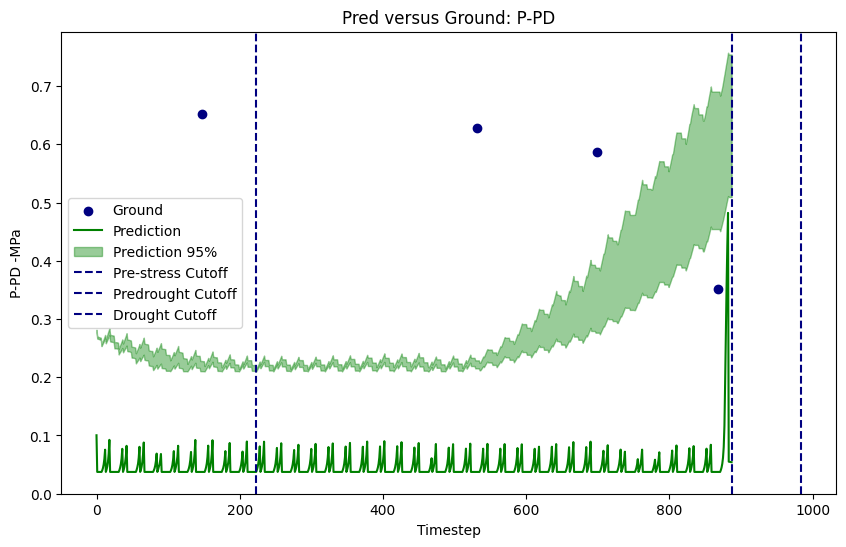

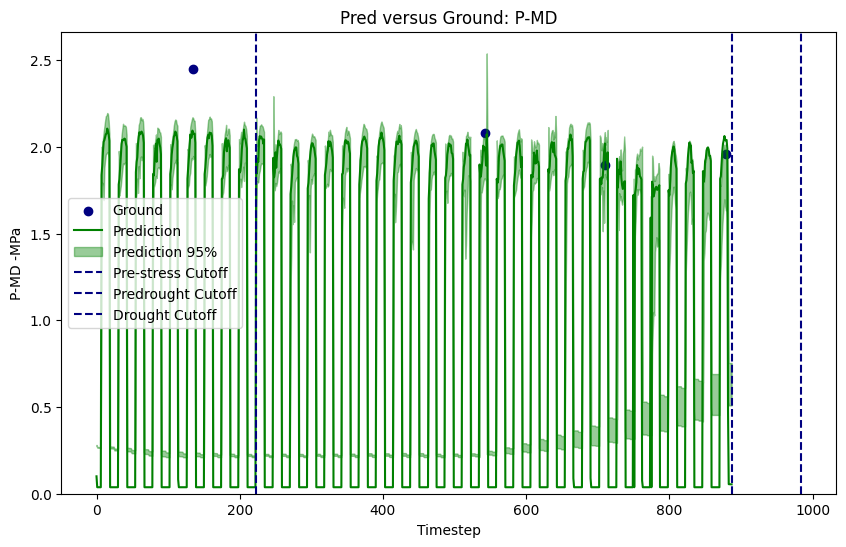

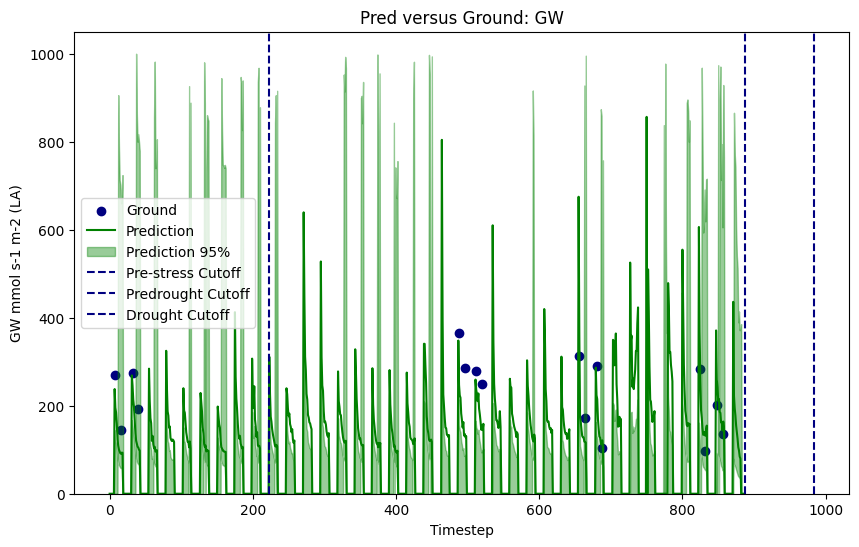

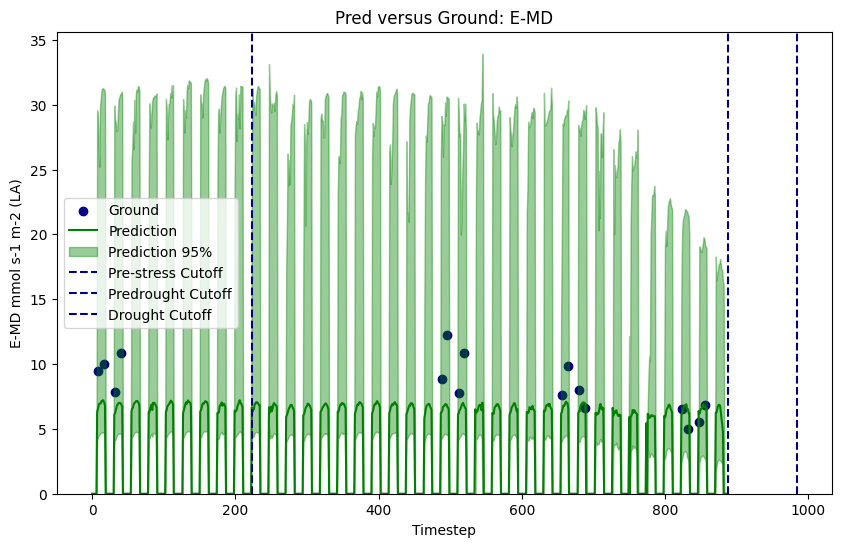

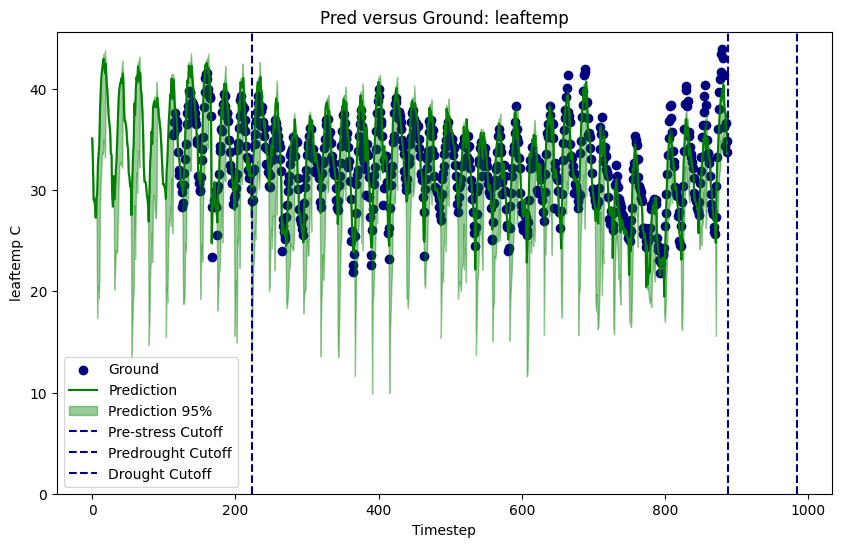

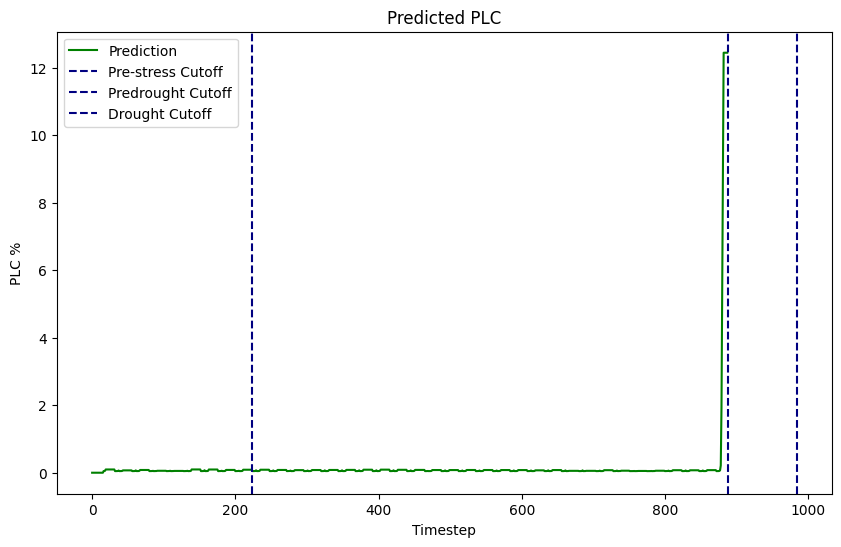

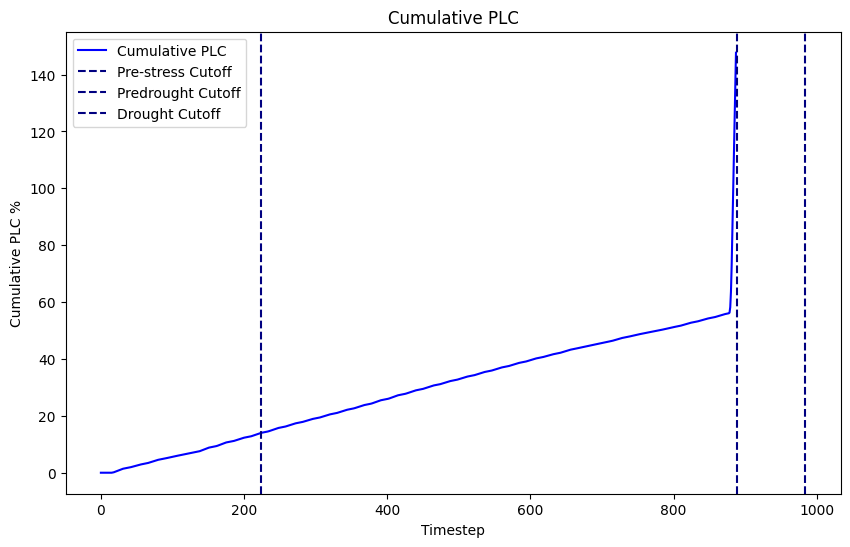

In [22]:
plot_ground_pred(columns, predrought_timestep)

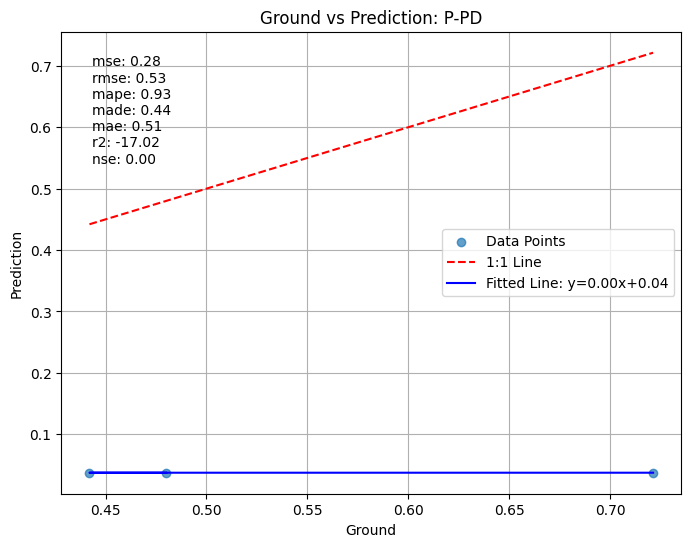

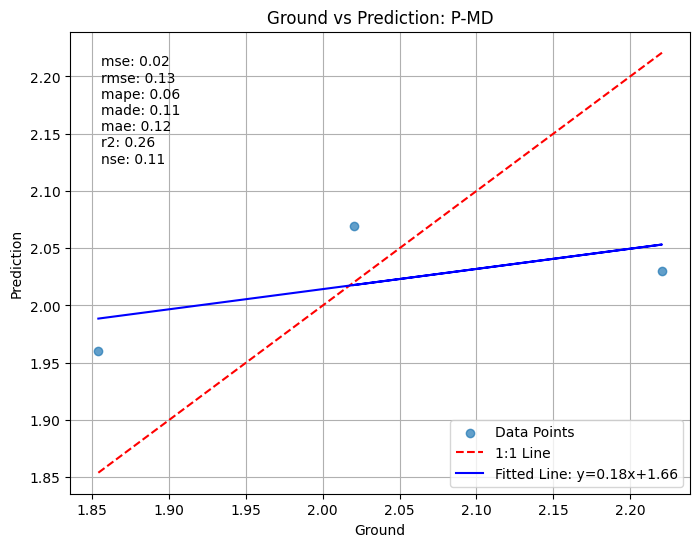

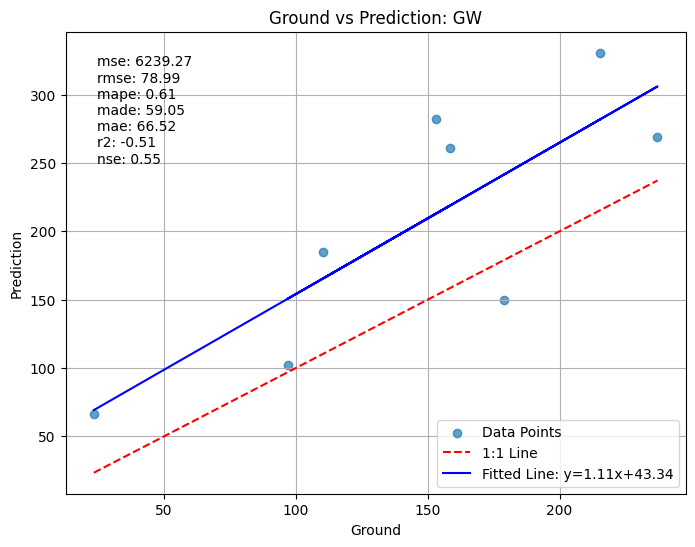

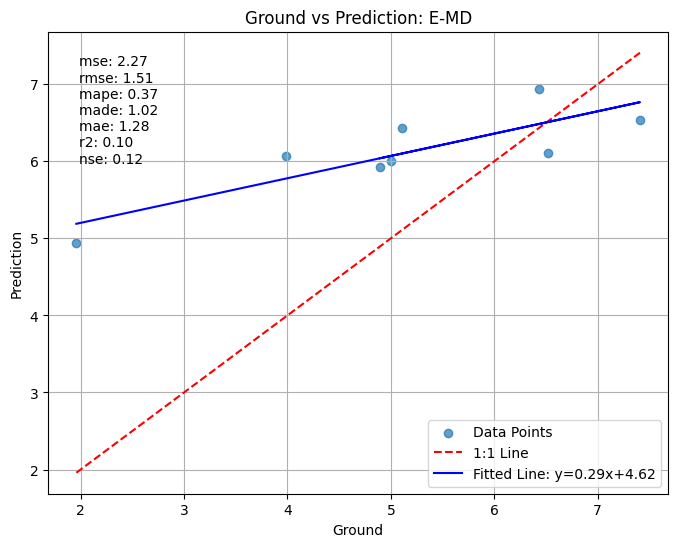

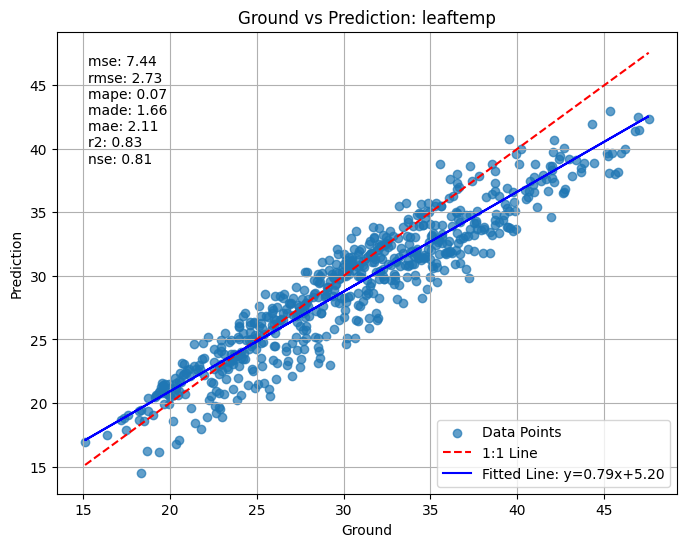

In [23]:
res = cmp_pred_to_ground_metrics(columns, ground, pred, drought, end_day)

In [24]:
res

{'P-PD': {'mse': 0.27576809780850225,
  'rmse': 0.5251362659429477,
  'mape': 0.9285072478166776,
  'made': np.float64(0.44258386806899996),
  'mae': 0.5103601040857778,
  'r2': -17.02237176419271,
  'nse': np.float64(3.519766127067371e-11)},
 'P-MD': {'mse': 0.016709111745239418,
  'rmse': 0.1292637294264691,
  'mape': 0.05588600486608785,
  'made': np.float64(0.1064444777739999),
  'mae': 0.11545768623522219,
  'r2': 0.2565193894091914,
  'nse': np.float64(0.10795952753034901)},
 'GW': {'mse': 6239.269365307845,
  'rmse': 78.98904585642141,
  'mape': 0.6147176119111498,
  'made': np.float64(59.0529939106281),
  'mae': 66.51887071131506,
  'r2': -0.5052174810282146,
  'nse': np.float64(0.554947451200197)},
 'E-MD': {'mse': 2.2744903790336157,
  'rmse': 1.5081413657325415,
  'mape': 0.3714955707417322,
  'made': np.float64(1.015776694533237),
  'mae': 1.2764966476809967,
  'r2': 0.1014228098553076,
  'nse': np.float64(0.11666634103048823)},
 'leaftemp': {'mse': 7.439557658655137,
  'rm

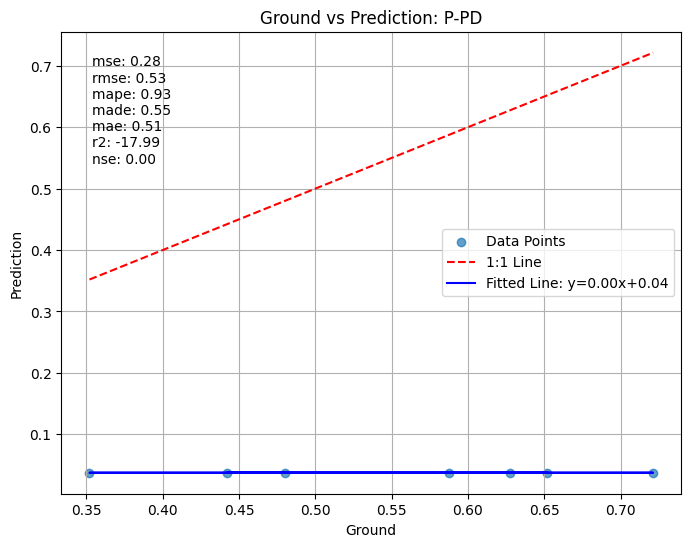

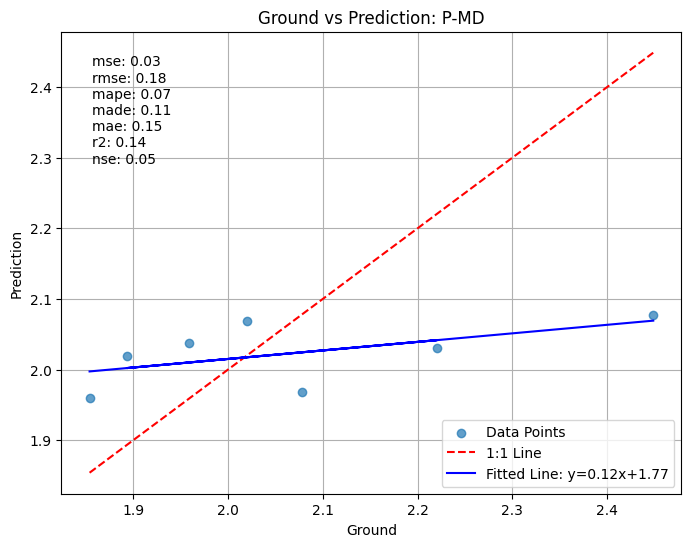

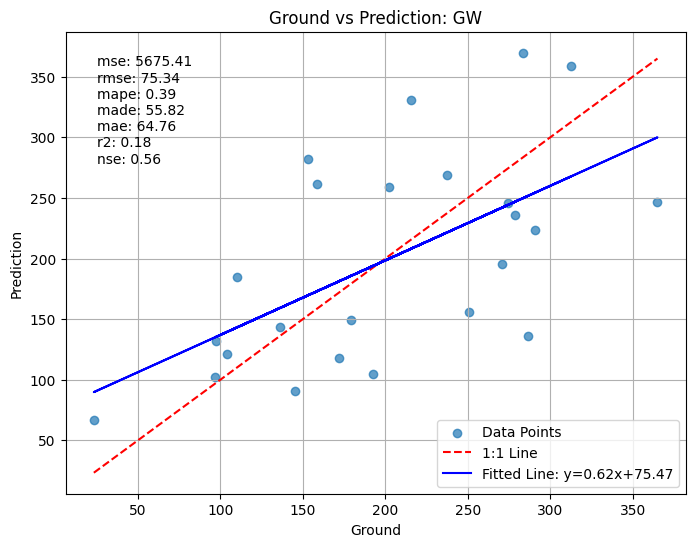

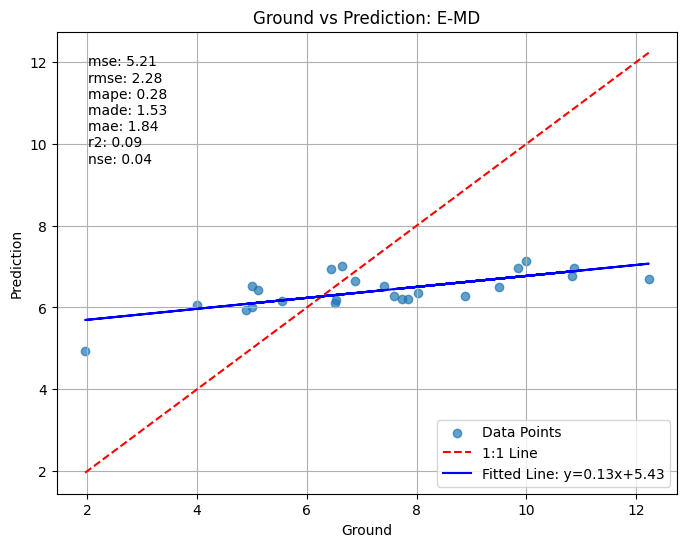

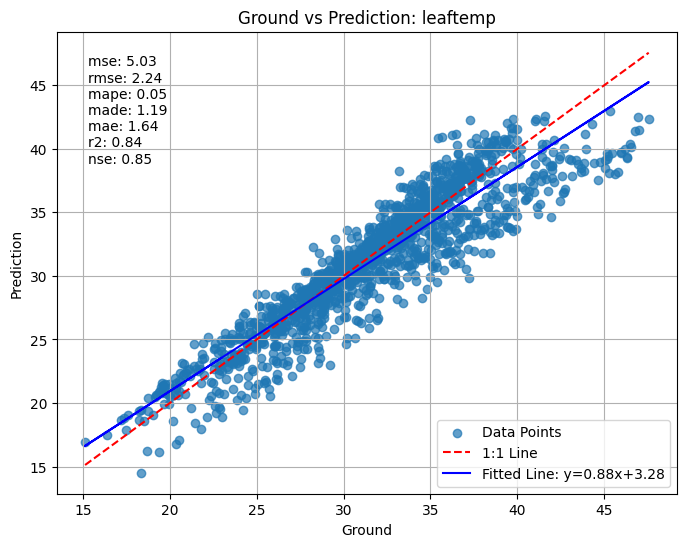

In [25]:
res = cmp_pred_to_ground_metrics(columns, ground, pred, start_day, end_day)

In [26]:
res

{'P-PD': {'mse': 0.2792202299646625,
  'rmse': 0.528412935084544,
  'mape': 0.9283565472317131,
  'made': np.float64(0.5499154952293334),
  'mae': 0.5143157027981904,
  'r2': -17.994399541373095,
  'nse': np.float64(2.1608352672367336e-11)},
 'P-MD': {'mse': 0.0317395947577097,
  'rmse': 0.17815609660550408,
  'mape': 0.06835790100788304,
  'made': np.float64(0.10908599233900018),
  'mae': 0.14735653713680952,
  'r2': 0.14127971295318442,
  'nse': np.float64(0.05189077641709962)},
 'GW': {'mse': 5675.412295696384,
  'rmse': 75.33533231954569,
  'mape': 0.39051038626572304,
  'made': np.float64(55.818669651998974),
  'mae': 64.76394993935277,
  'r2': 0.17622210650778747,
  'nse': np.float64(0.5611471185088442)},
 'E-MD': {'mse': 5.213667522061049,
  'rmse': 2.2833456860626797,
  'mape': 0.27858613504594176,
  'made': np.float64(1.5304038700744065),
  'mae': 1.843089207992902,
  'r2': 0.09295621933110798,
  'nse': np.float64(0.039273547047891495)},
 'leaftemp': {'mse': 5.02524569796854,


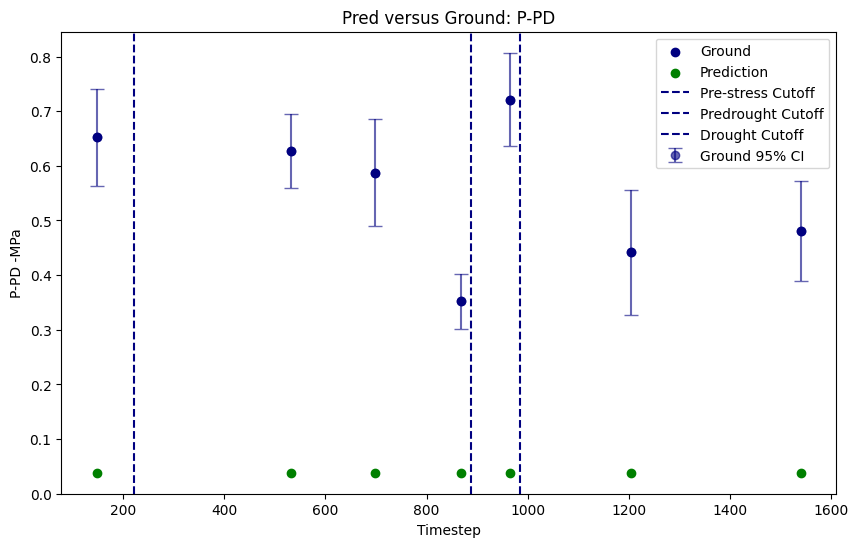

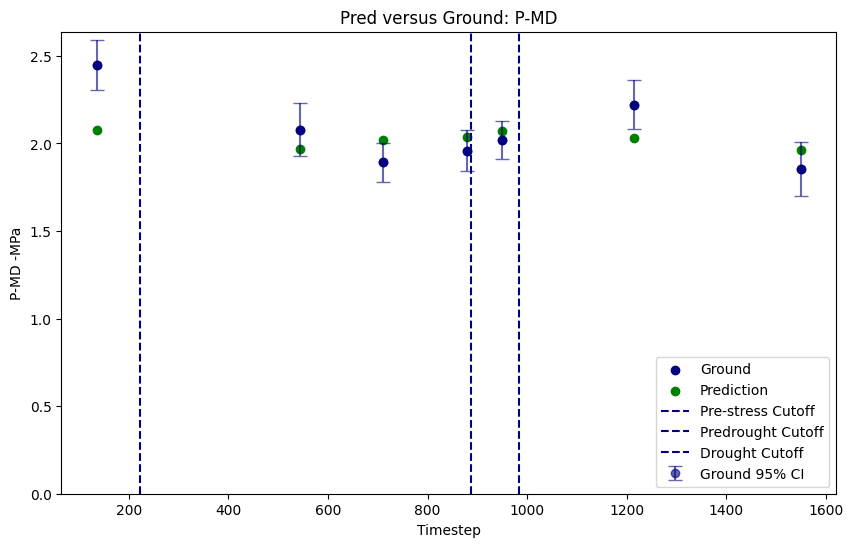

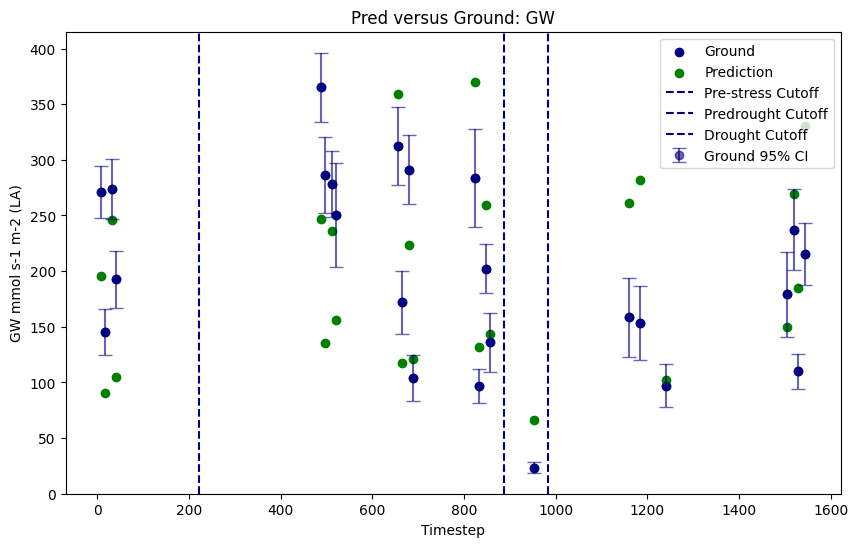

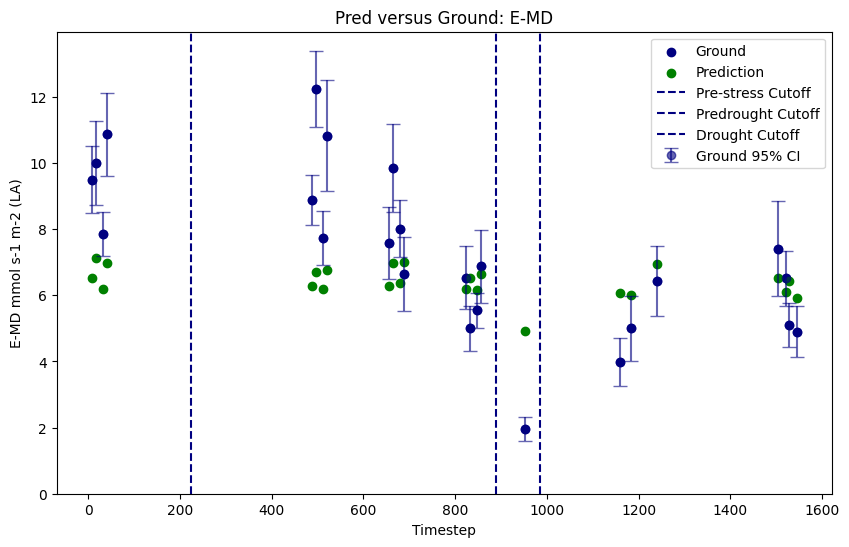

In [27]:
plot_ground_pred_two(columns[:-1], len(pred))

Ground


,P-PD,P-MD,GW,E-MD,leaftemp
count,7.000000,7.000000,24.000000,24.000000,1447.000000
mean,0.551733,2.067714,201.469900,7.300970,31.716180
std,0.130959,0.207658,84.788186,2.449059,5.604320
min,0.352000,1.854000,23.311111,1.958475,15.127778
25%,0.461000,1.926333,143.009259,5.432804,28.017778
50%,0.587333,2.020000,197.446970,7.142836,31.914444
75%,0.639733,2.149333,275.268098,9.028770,35.400000
max,0.721333,2.448667,365.000000,12.229683,47.560000


Pred


,P-PD,P-MD,GW,E-MD,leaftemp
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,0.049462,0.963459,98.805976,3.194334,31.573920
std,0.038663,0.947081,132.513956,3.281924,5.420235
min,0.037415,0.037415,0.000000,0.000000,14.518888
25%,0.037418,0.037418,0.000000,0.000000,27.967314
50%,0.037420,0.081699,0.000000,0.000000,31.806074
75%,0.051383,1.943898,162.442733,6.587722,35.507661
max,0.494611,2.106000,856.385790,7.214819,42.982624


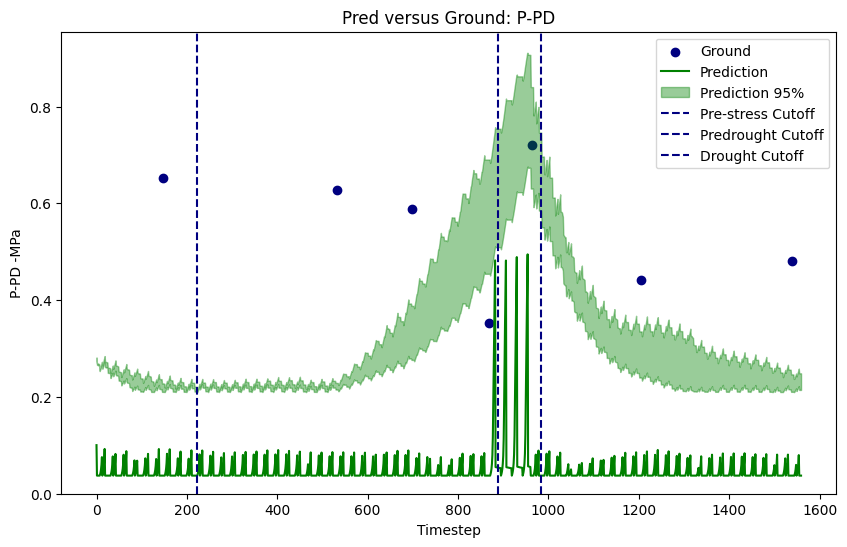

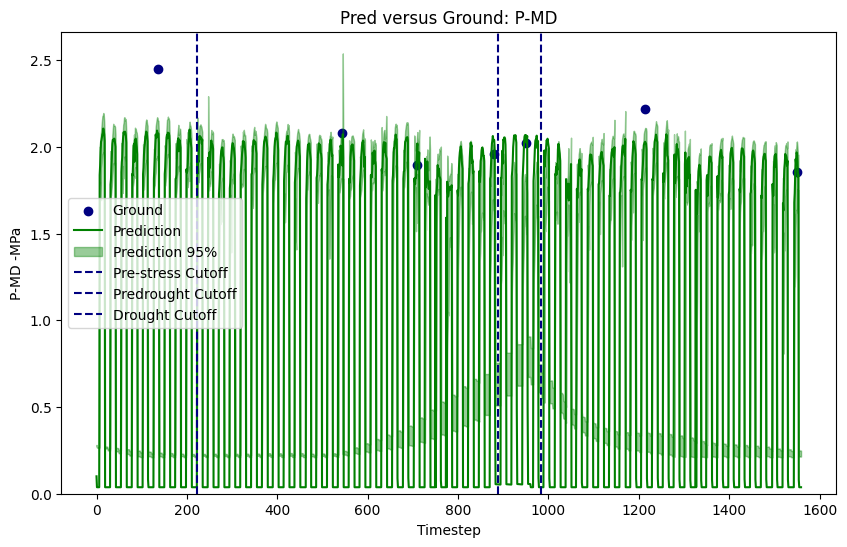

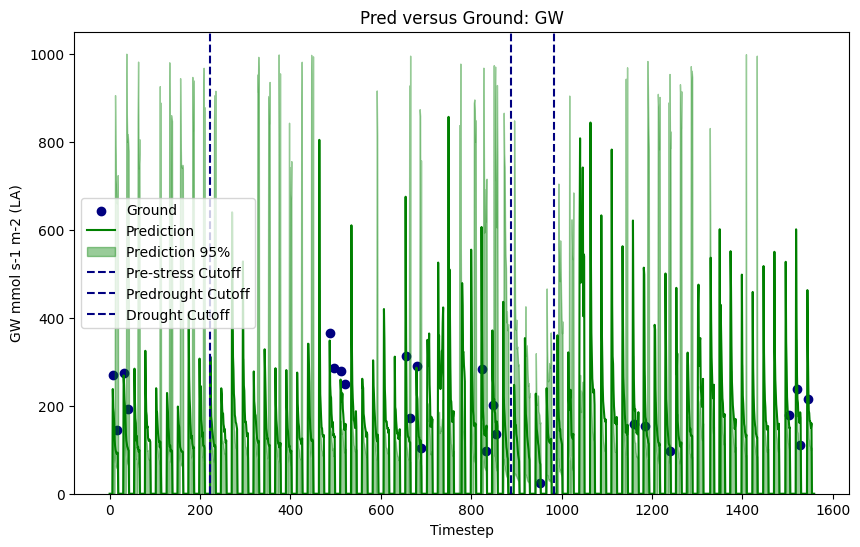

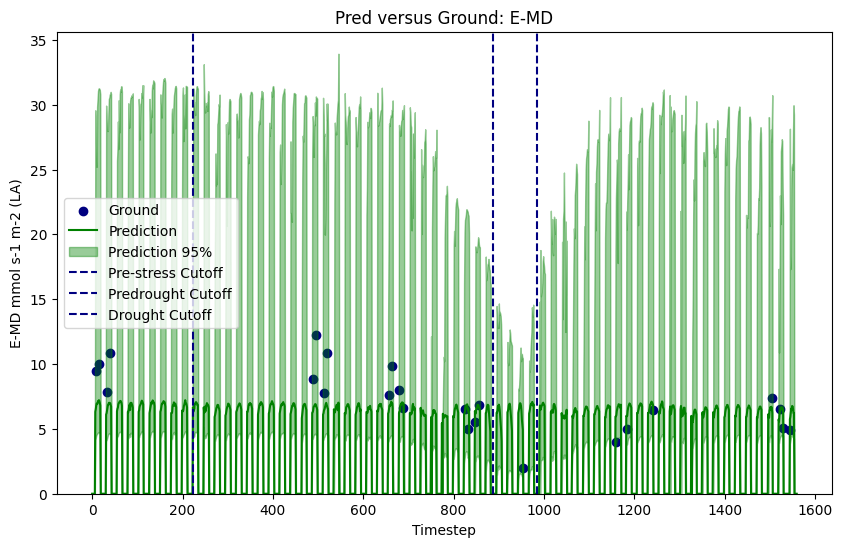

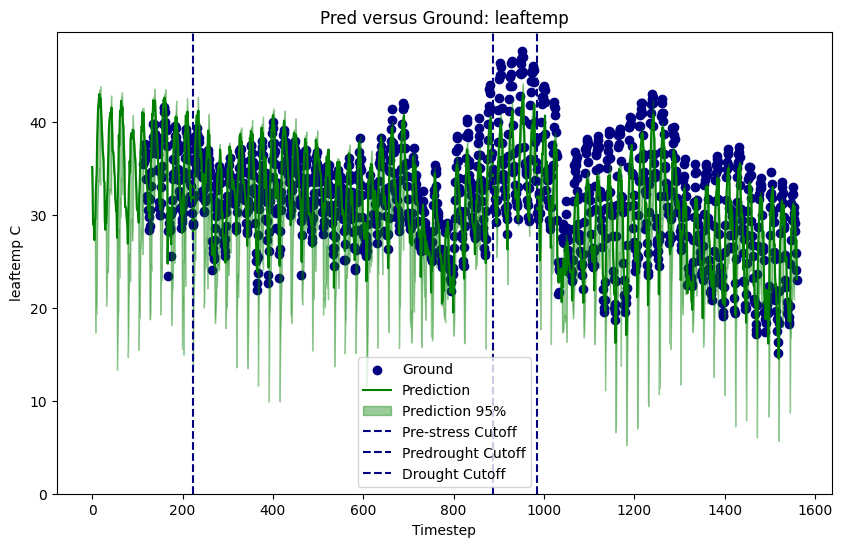

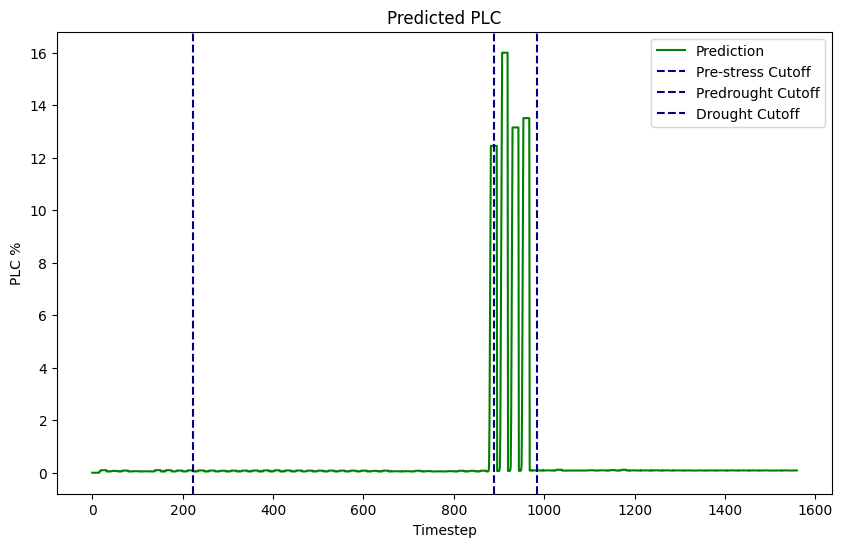

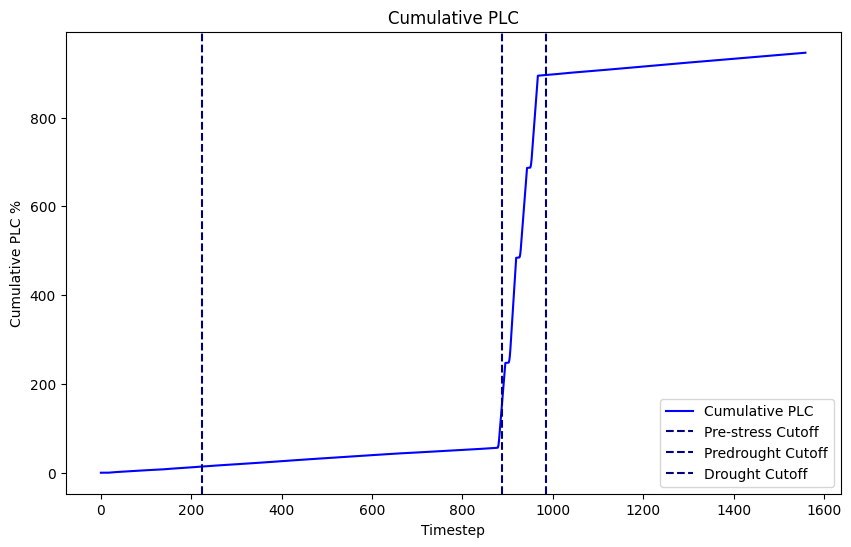

In [28]:
plot_ground_pred(columns, len(pred))

In [29]:
def plot_diurnal(var, day):
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, 24), pred.loc[pred['julian-day'] == day][var], label='Prediction', color='green')
    plt.fill_between(range(0, 24), low.loc[low['julian-day'] == day][var], high.loc[high['julian-day'] == day][var], color='green', alpha=0.4)
    col_ground = ground.loc[(ground['julian-day'] == day)][[var, 'standard-time']].dropna()
    plt.scatter(col_ground['standard-time'], col_ground[var], label='Ground Truth', color='navy')
    
    m_ground = ground.loc[(ground['julian-day'] == day)].set_index(['standard-time'])[[var]].dropna()
    m_stderr = stderr.loc[(ground['julian-day'] == day)].set_index(['standard-time'])[[var]].dropna()
    xerr, yerr = get_errors(m_ground, m_stderr)
    for i, (_, row) in enumerate(m_ground.iterrows()):
        plt.errorbar(
            row.name,
            row[var],
            yerr=1.96 * yerr[i],
            xerr=np.expand_dims(xerr[:, i], axis=1),
            color='navy'
        )

    plt.xticks(range(0, 24))
    plt.xlim(0, 23)  # Ensure no gap on the left side of the origin
    plt.ylim(0, np.minimum(1000, np.max(pred[var]) + 0.1 * np.max(pred[var])))
    plt.xlabel('Hour of Day')
    plt.ylabel(var)
    plt.title(f'Diurnal Plot of {var} on Julian Day {day}')
    plt.legend()
    plt.grid(False)
    plt.show()

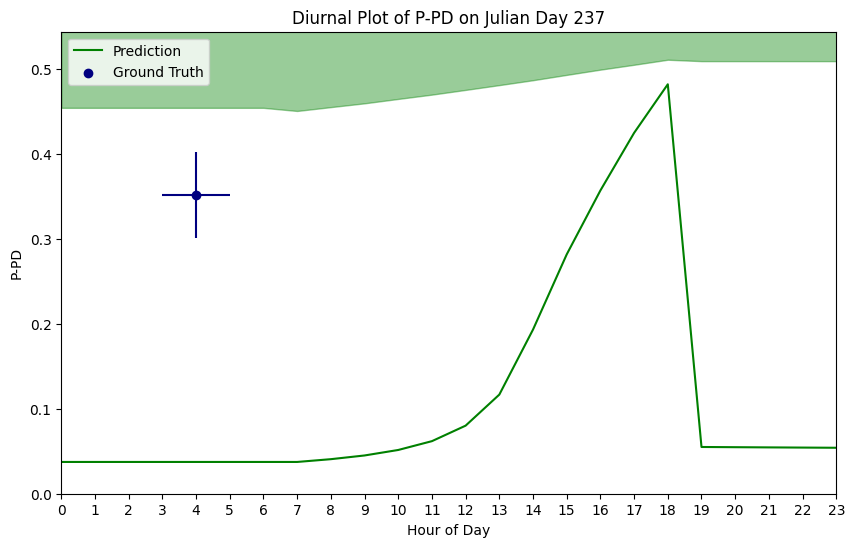

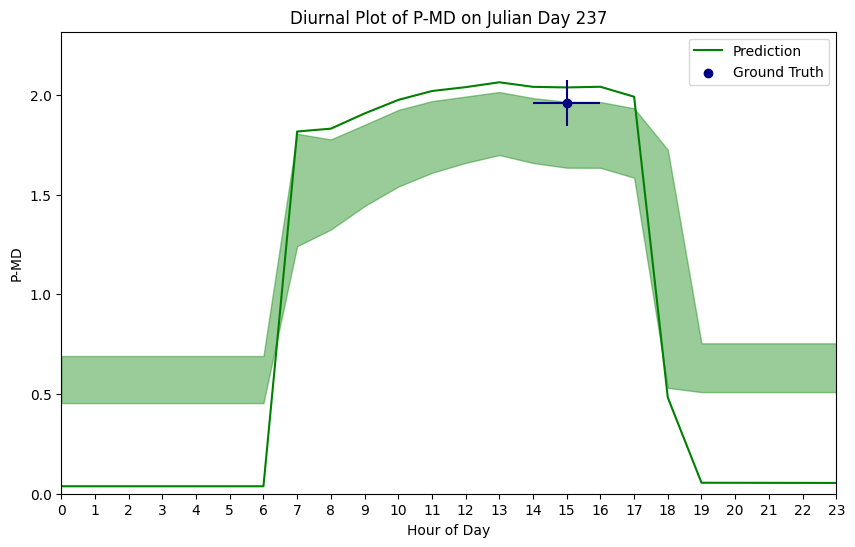

In [30]:
day=237
plot_diurnal('P-PD', day=day)
plot_diurnal('P-MD', day=day)

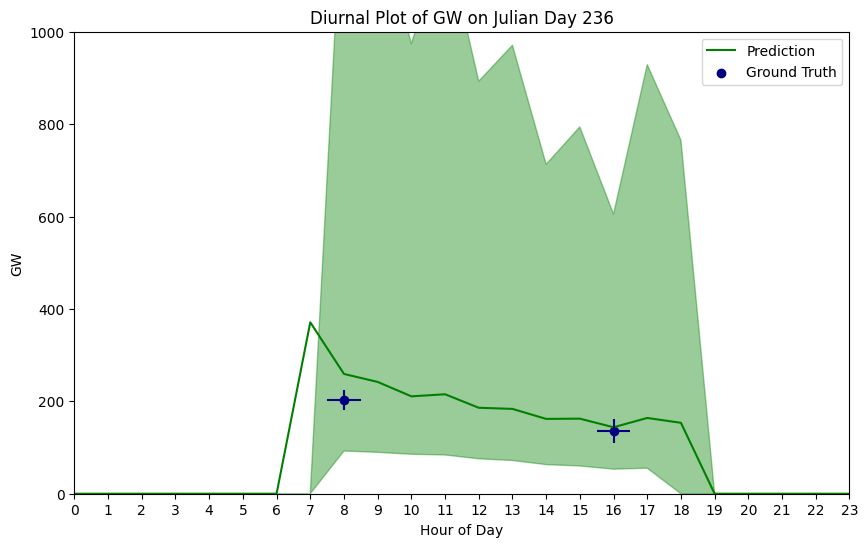

In [31]:
day=236
plot_diurnal('GW', day=day)

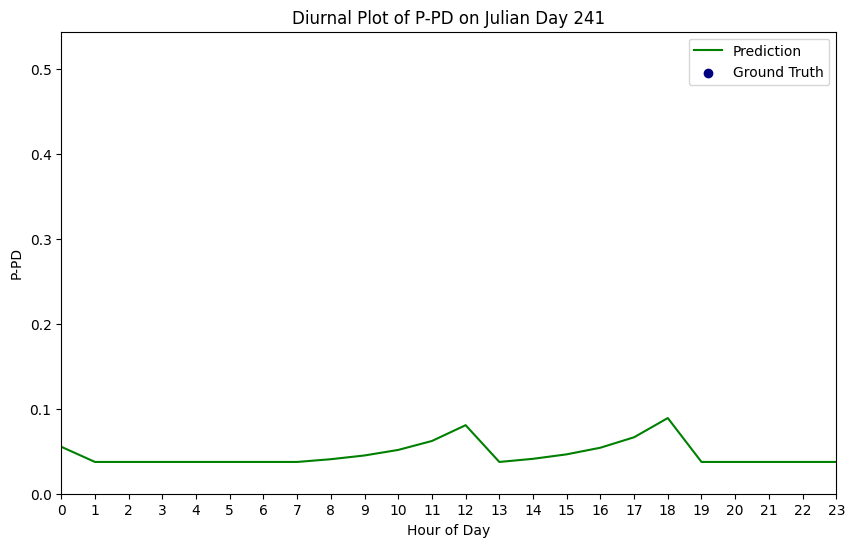

In [32]:
day = 241
plot_diurnal('P-PD', day=day)

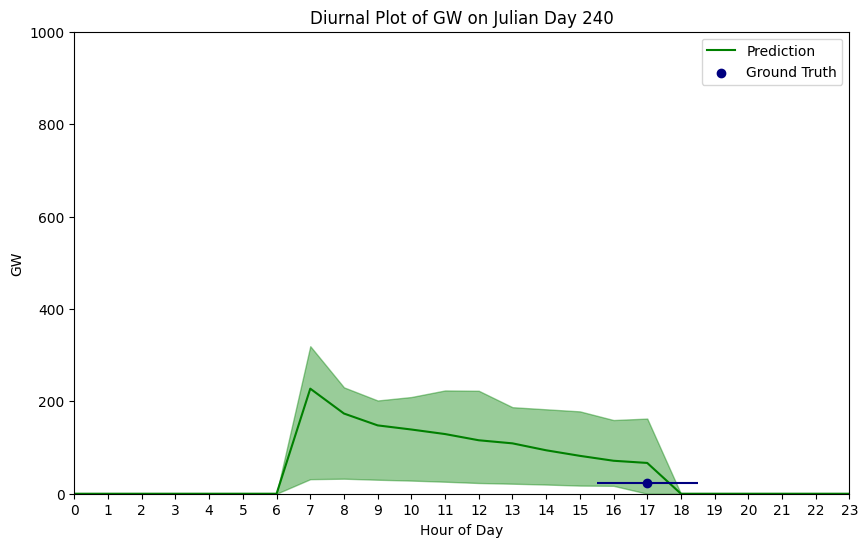

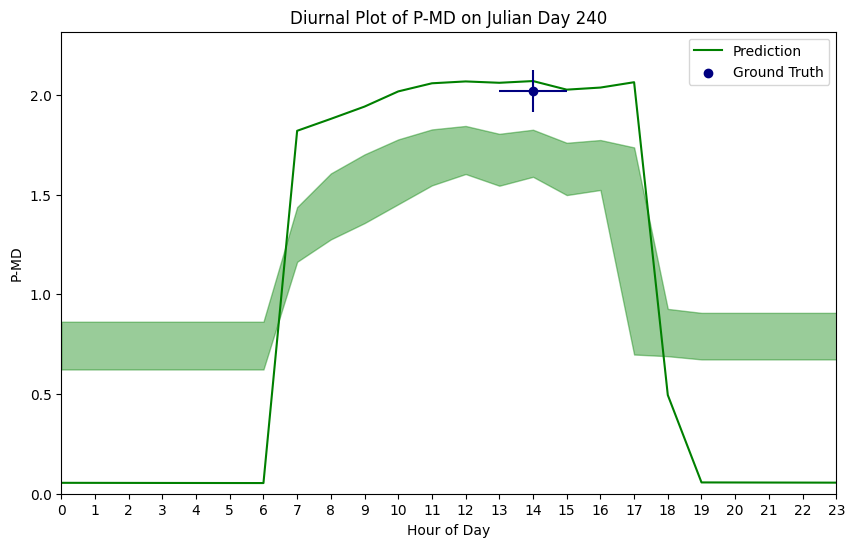

In [33]:
day=240
plot_diurnal('GW', day=day)
plot_diurnal('P-MD', day=day)

In [34]:
""" From Posch et al.
Mean Tleaf calculated as average of Tleaf measured at 15 min intervals between 14:00 to 18:00
each day in three pseudoreplicate leaves per tree, and three replicate trees per population. (B) The difference between Tleaf and air temperature (Tair) was also
calculated for the same period.
"""
daily_ground_leaft_mean = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].mean()
daily_pred_leaft_mean = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].mean()
daily_low_leaft_mean = low[(low['standard-time'] >= 14) & (low['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].mean()
daily_high_leaft_mean = high[(high['standard-time'] >= 14) & (high['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].mean()

# Calculate daily mean of (leaftemp - T-air) for ground and predictions, 14:00-18:00
daily_ground_diff_mean = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['Tair_C']).mean(), include_groups=False)
daily_pred_diff_mean = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['T-air']).mean(), include_groups=False)
daily_low_diff_mean = low[(low['standard-time'] >= 14) & (low['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['T-air']).mean(), include_groups=False)
daily_high_diff_mean = high[(high['standard-time'] >= 14) & (high['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['T-air']).mean(), include_groups=False)

In [35]:
daily_pred_leaft_count = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].count()
daily_pred_leaft_std = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].std()
daily_pred_leaft_stderr = daily_pred_leaft_std / np.sqrt(daily_pred_leaft_count)

daily_ground_leaft_count = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].count()
daily_ground_leaft_std = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day')['leaftemp'].std()
daily_ground_leaft_stderr = daily_ground_leaft_std / np.sqrt(daily_ground_leaft_count)

daily_pred_diff_count = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: df['leaftemp'].count(), include_groups=False)
daily_pred_diff_std = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['T-air']).std(), include_groups=False)
daily_pred_diff_stderr = daily_pred_diff_std / np.sqrt(daily_pred_diff_count)

daily_ground_diff_count = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: df['leaftemp'].count(), include_groups=False)
daily_ground_diff_std = leaft[(leaft['standard-time'] >= 14) & (leaft['standard-time'] <= 18)].groupby('julian-day').apply(lambda df: (df['leaftemp'] - df['Tair_C']).std(), include_groups=False)
daily_ground_diff_stderr = daily_ground_diff_std / np.sqrt(daily_ground_diff_count)

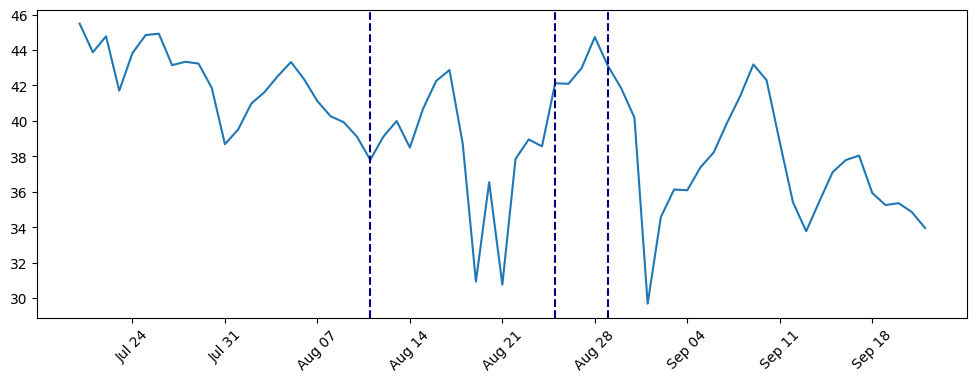

In [36]:
plt.figure(figsize=(12,4))
plt.plot(pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day').max().loc[pred['julian-day'] >= leaft_data_start]['T-air'])
plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
plt.axvline(x=predrought_cutoff, color='navy', linestyle='--', label='Predrought Cutoff')
plt.axvline(x=post_drought, color='navy', linestyle='--', label='Drought Cutoff')

# Generate date labels from July 24th to September 25th
start_date = datetime(2023, 7, 3)
end_date = datetime(2023, 9, 25)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

julian_days = pred[(pred['standard-time'] >= 14) & (pred['standard-time'] <= 18)].groupby('julian-day').max().loc[pred['julian-day'] >= leaft_data_start]['T-air'].index
tick_indices = []
tick_labels = []
for i, date in enumerate(date_range):
    if i % 7 != 0:
        continue
    jd = date.timetuple().tm_yday
    if jd in julian_days:
        tick_indices.append(jd)
        tick_labels.append(date.strftime('%b %d'))

plt.xticks(tick_indices, tick_labels, rotation=45)
plt.show()

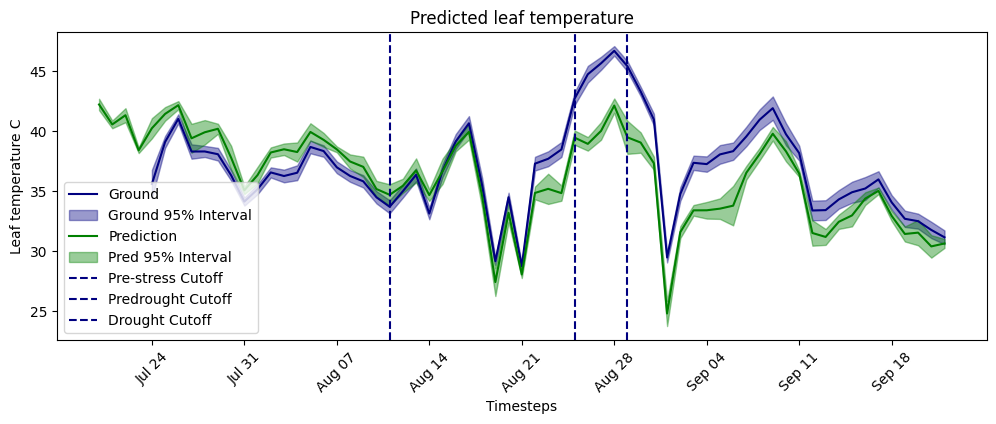

In [37]:
plt.figure(figsize=(12,4))

plt.plot(daily_ground_leaft_mean.index, daily_ground_leaft_mean.values, color="navy", alpha=1, label=f'Ground')
plt.fill_between(daily_ground_leaft_stderr.index, daily_ground_leaft_mean.values - 1.96 * daily_ground_leaft_stderr.values, daily_ground_leaft_mean.values + 1.96 * daily_ground_leaft_stderr.values, color='navy', alpha=0.4, label="Ground 95% Interval")

plt.plot(daily_pred_leaft_mean.index, daily_pred_leaft_mean.values, color="green", alpha=1, label=f'Prediction')
plt.fill_between(daily_pred_leaft_stderr.index, daily_pred_leaft_mean.values - 1.96 * daily_pred_leaft_stderr.values, daily_pred_leaft_mean.values + 1.96 * daily_pred_leaft_stderr.values, color='green', alpha=0.4, label="Pred 95% Interval")
# plt.fill_between(daily_high_leaft_mean.index, daily_low_leaft_mean.values, daily_high_leaft_mean.values, color='green', alpha=0.4, label="95% Interval")

plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
plt.axvline(x=predrought_cutoff, color='navy', linestyle='--', label='Predrought Cutoff')
plt.axvline(x=post_drought, color='navy', linestyle='--', label='Drought Cutoff')
plt.xlabel("Timesteps")
plt.ylabel("Leaf temperature C")

# Generate date labels from July 24th to September 25th
start_date = datetime(2023, 7, 24)
end_date = datetime(2023, 9, 25)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Set x-ticks at the corresponding julian-day indices
julian_days = daily_ground_diff_mean.index
tick_indices = []
tick_labels = []
for i, date in enumerate(date_range):
    if i % 7 != 0:
        continue
    jd = date.timetuple().tm_yday
    if jd in julian_days:
        tick_indices.append(jd)
        tick_labels.append(date.strftime('%b %d'))

plt.xticks(tick_indices, tick_labels, rotation=45)
plt.title("Predicted leaf temperature")
plt.legend()

# plt.xlim(start_day, predrought_cutoff)
plt.show()

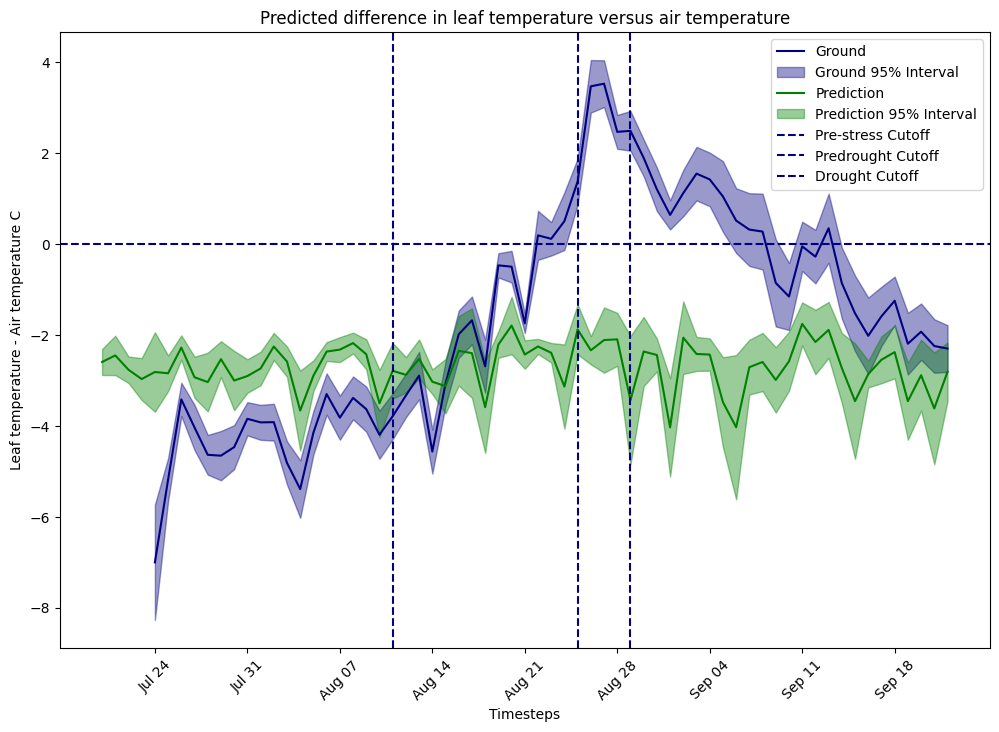

In [38]:
plt.figure(figsize=(12,8))
plt.plot(daily_ground_diff_mean.index, daily_ground_diff_mean.values, color="navy", alpha=1, label=f'Ground')
plt.fill_between(daily_ground_diff_stderr.index, daily_ground_diff_mean.values - 1.96 * daily_ground_diff_stderr.values, daily_ground_diff_mean.values + 1.96 * daily_ground_diff_stderr.values, color='navy', alpha=0.4, label="Ground 95% Interval")

plt.plot(daily_pred_diff_mean.index, daily_pred_diff_mean.values, color="green", alpha=1, label=f'Prediction')
plt.fill_between(daily_pred_diff_stderr.index, daily_pred_diff_mean.values - 1.96 * daily_pred_diff_stderr.values, daily_pred_diff_mean.values + 1.96 * daily_pred_diff_stderr.values, color='green', alpha=0.4, label="Prediction 95% Interval")

# plt.fill_between(daily_high_diff_mean.index, daily_low_diff_mean.values, daily_high_diff_mean.values, color='green', alpha=0.4, label="95% Interval")

plt.axvline(x=stress_begin, color='navy', linestyle='--', label='Pre-stress Cutoff')
plt.axvline(x=predrought_cutoff, color='navy', linestyle='--', label='Predrought Cutoff')
plt.axvline(x=post_drought, color='navy', linestyle='--', label='Drought Cutoff')
plt.axhline(y=0, color='navy', linestyle='--')
plt.xlabel("Timesteps")
plt.ylabel("Leaf temperature - Air temperature C")

# Generate date labels from July 24th to September 25th
start_date = datetime(2023, 7, 24)
end_date = datetime(2023, 9, 25)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Set x-ticks at the corresponding julian-day indices
julian_days = daily_ground_diff_mean.index
tick_indices = []
tick_labels = []
for i, date in enumerate(date_range):
    if i % 7 != 0:
        continue
    jd = date.timetuple().tm_yday
    if jd in julian_days:
        tick_indices.append(jd)
        tick_labels.append(date.strftime('%b %d'))

plt.xticks(tick_indices, tick_labels, rotation=45)
plt.title("Predicted difference in leaf temperature versus air temperature")
plt.legend()

# plt.xlim(start_day, predrought_cutoff)
plt.show()

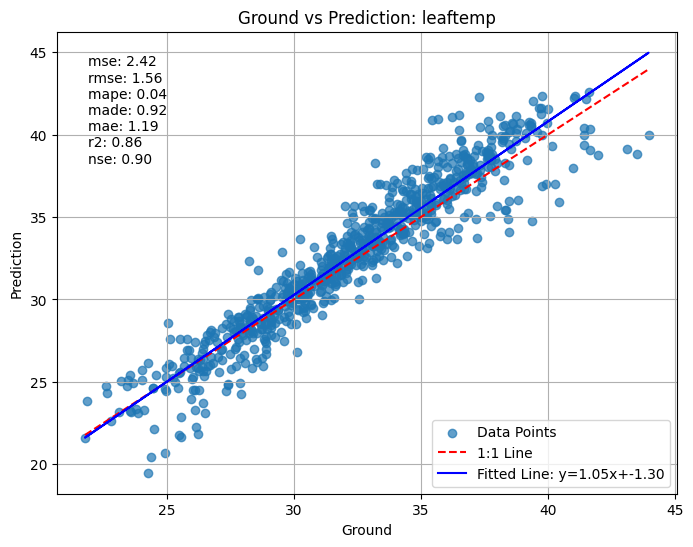

In [39]:
res = cmp_pred_to_ground_metrics(['leaftemp'], ground, pred, start_day, predrought_cutoff)

In [40]:
res

{'leaftemp': {'mse': 2.420849354435235,
  'rmse': 1.5559078875162355,
  'mape': 0.036660798872432517,
  'made': np.float64(0.9239886135540019),
  'mae': 1.1879477938798937,
  'r2': 0.8596672988081773,
  'nse': np.float64(0.8980544543084639)}}

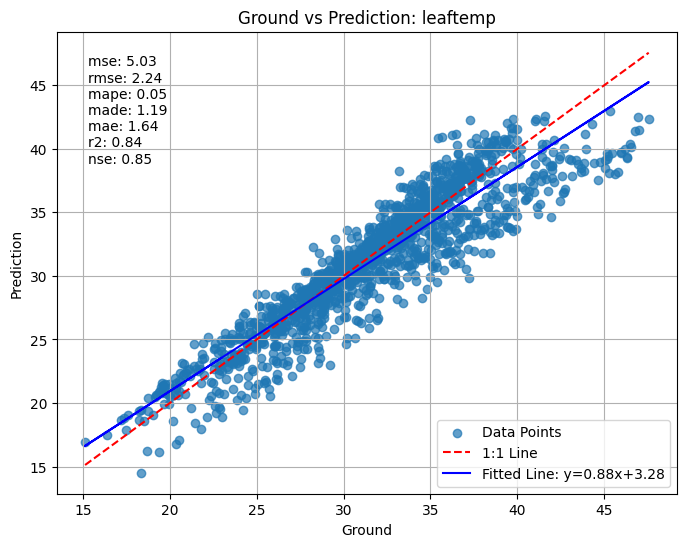

In [41]:
res = cmp_pred_to_ground_metrics(['leaftemp'], ground, pred, start_day, end_day)

In [42]:
res

{'leaftemp': {'mse': 5.02524569796854,
  'rmse': 2.2417059793756495,
  'mape': 0.050967221600734205,
  'made': np.float64(1.192641346792108),
  'mae': 1.644174847940644,
  'r2': 0.8398924798586981,
  'nse': np.float64(0.8515564213828862)}}